# Audio Recoginition

## Audio Content & Gender Classification

#### About the dataset

The dataset consists of 10.8k audio tracks. Each of the audio track records the waveform of an audio recording of a human reading out digit (ie. from 0-9). Your task is to train two classification neural networks that **identify the digit** that has been uttered and **identify the gender**.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *input.npy*
    - *gender.npy*
    - *digit.npy*

The *input.npy* has a shape of (10800, 8000) which indicates 10800 waveforms and 8000 samples from each waveform. Each waveform is normalised with 1 second duration and 8 kHz sampling frequnecy. The *gender.npy* and *digit.npy* files contains the correspondent target information of the 10800 waveforms in the same order.

In [1]:
# !rm -rf /kaggle/working/*
! rm -rf /workspace/working/*

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
! rm -rf /usr/local/lib/python3.11/dist-packages/~umpy*

In [4]:
! pip install --upgrade pip setuptools wheel
! pip install --upgrade scikit-learn numpy soundfile
! pip install audiomentations[extras]
! pip install --force-reinstall numpy==1.26.4
! pip install tensorflow==2.18.0
! pip install tensorflow-io
! pip install ipykernel ipywidgets ipython

  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver 

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
! pip install pandas matplotlib seaborn scikit-image kagglehub kaggle
! apt update && apt install -y zip
! apt upgrade -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/nightly/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
4 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zip is already the newest version (3.0-12build2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state informati

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
print("GPUs:", gpus)

2025-07-06 01:06:13.027596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751763973.049356  154883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751763973.055979  154883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 01:06:13.080699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Num GPUs Available: 2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
! python -c "from audiomentations import Compose, AddGaussianNoise; print('Audiomentations is ready')"

Audiomentations is ready


In [10]:
%pwd

'/workspace/working'

In [6]:
import os
import scipy
import librosa
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from skimage.transform import resize
from IPython.display import clear_output, Audio
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, model_from_json
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Flatten, Dropout
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
import random
import json
import pprint
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import random
import gc
from audiomentations import Compose, AddGaussianNoise, Gain, Shift, TimeStretch, PitchShift, SevenBandParametricEQ
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_io as tfio

# To ensure everything is tensorflow related and supported at the nackend
os.environ["KERAS_BACKEND"] = "tensorflow"

In [7]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("ritisheditor/audiowaveform-dataset")

print("Path to dataset files:", dataset_path)

# dataset_path = '/kaggle/input/audiowaveform-dataset'

x = np.load(f'{dataset_path}/xtrain.npy')
x_copy = x.copy()

y_num = np.load(f'{dataset_path}/ytrain_num.npy').astype("int16")
y_num_copy = y_num.copy()

y_gender = np.load(f'{dataset_path}/ytrain_gender.npy').astype("int16")
y_gender_copy = y_gender.copy()

Path to dataset files: /root/.cache/kagglehub/datasets/ritisheditor/audiowaveform-dataset/versions/1


In [13]:
print(y_gender[0])
print(y_num[0])
Audio(x[0].squeeze(), rate = 8000)

0
0


In [14]:
x[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [15]:
temp = []
for i in range(0, x[0].shape[0]):
    if x[0][i] != 0:
        temp.append(x[0][i])

print(temp)

[-8, -8, -7, -9, -9, -8, -9, -8, -9, -10, -8, -8, -9, -10, -11, -10, -10, -12, -11, -12, -12, -11, -11, -10, -10, -8, -8, -8, -8, -8, -9, -9, -8, -9, -9, -8, -9, -9, -8, -8, -9, -8, -9, -9, -8, -7, -7, -7, -7, -7, -8, -8, -8, -8, -6, -9, -7, -6, -6, -5, -5, -5, -5, -5, -6, -8, -8, -9, -10, -10, -10, -10, -8, -10, -10, -10, -10, -9, -9, -9, -10, -9, -10, -9, -10, -10, -8, -9, -9, -9, -9, -9, -9, -10, -9, -9, -8, -7, -5, -7, -6, -7, -6, -7, -7, -8, -7, -8, -6, -7, -6, -6, -7, -7, -8, -7, -7, -8, -8, -7, -7, -8, -8, -7, -7, -7, -6, -7, -6, -6, -5, -7, -7, -6, -6, -6, -5, -5, -4, -5, -3, -4, -5, -4, -3, -4, -4, -4, -4, -3, -3, -2, -3, -2, 1, 2, 2, 3, 3, 6, 2, 5, 4, 4, 3, 4, 4, 4, 3, 4, 5, 5, 5, 3, 5, 5, 4, 4, 4, 7, 7, 8, 8, 8, 7, 8, 8, 8, 6, 4, 4, 4, 5, 3, 4, 3, 4, 3, 2, 2, 3, 2, 2, 3, 3, 4, 5, 6, 6, 8, 7, 8, 7, 8, 8, 10, 8, 8, 8, 7, 7, 8, 7, 8, 9, 9, 10, 8, 6, 7, 6, 8, 8, 9, 8, 9, 8, 6, 6, 7, 7, 9, 7, 9, 8, 10, 10, 11, 10, 10, 9, 9, 9, 9, 8, 9, 10, 10, 10, 11, 9, 9, 9, 11, 10, 10, 11, 10,

[0 1] : [9600 1200]


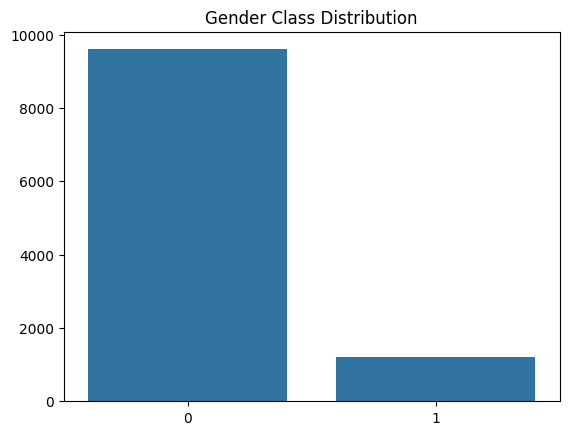

In [16]:
classes, counts = np.unique(y_gender_copy, return_counts = True)
print(f"{classes} : {counts}")
sns.barplot(x = classes, y = counts)
plt.title("Gender Class Distribution")
plt.show()

[0 1 2 3 4 5 6 7 8 9] : [1080 1080 1080 1080 1080 1080 1080 1080 1080 1080]


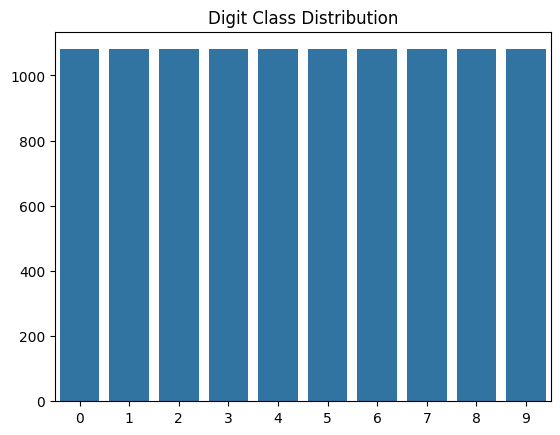

In [17]:
classes, counts = np.unique(y_num_copy, return_counts = True)
print(f"{classes} : {counts}")
sns.barplot(x = classes, y = counts)
plt.title("Digit Class Distribution")
plt.show()

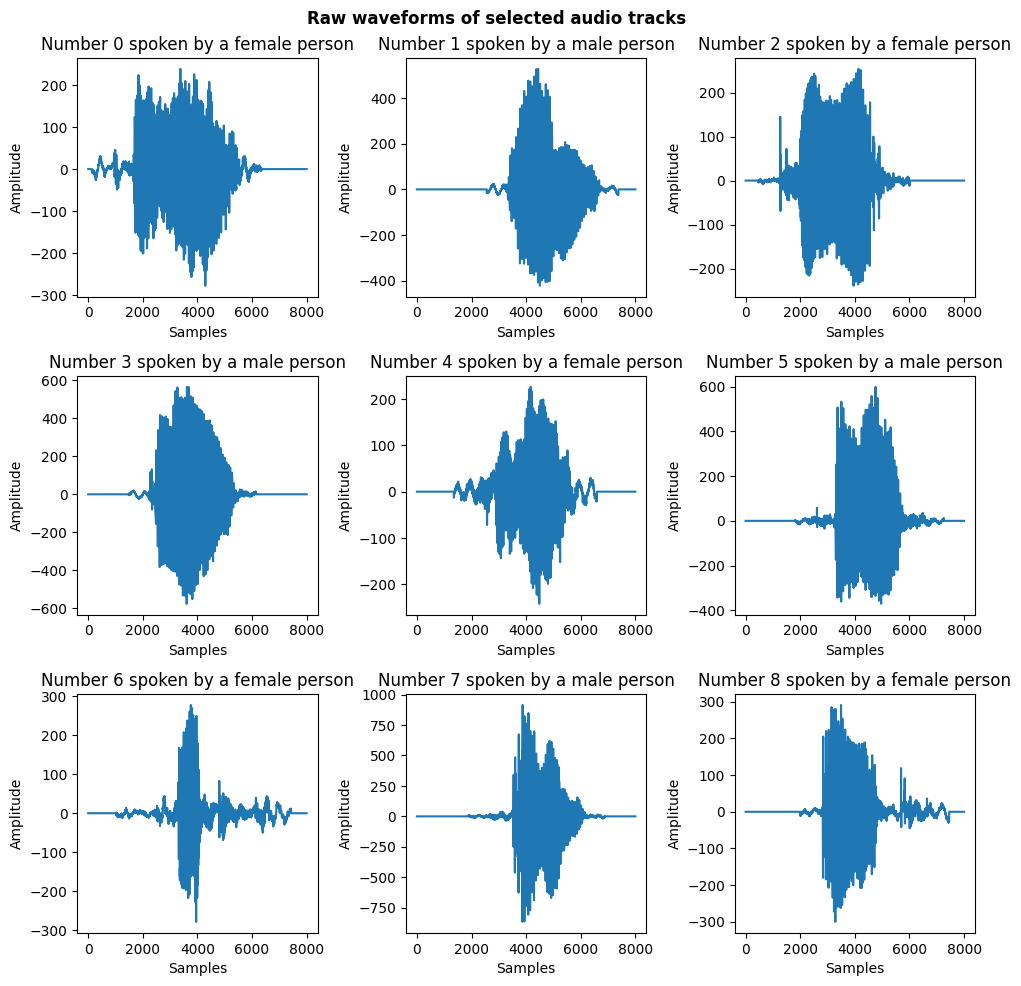

In [18]:
# The code below takes the same samples for the 0-9 digits by females and males
# and display the waveforms asscociated with each of the selected audio files.

gender_ = 0
fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs1.ravel()):
    # Wanted to show some variety in the genders, so alternating genders
    # and seeking the next sample with correct gender/digit
    gender_ = 1 - gender_
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

    # extracting the waveform and the labels
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]

    # label 0 is Male and 1 is Female
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    ax.plot(
        list(range(1, 8000 + 1, 1)),
        audio_track,
    )
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples')
    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

fig1.suptitle(
    'Raw waveforms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig1.tight_layout(pad=1)

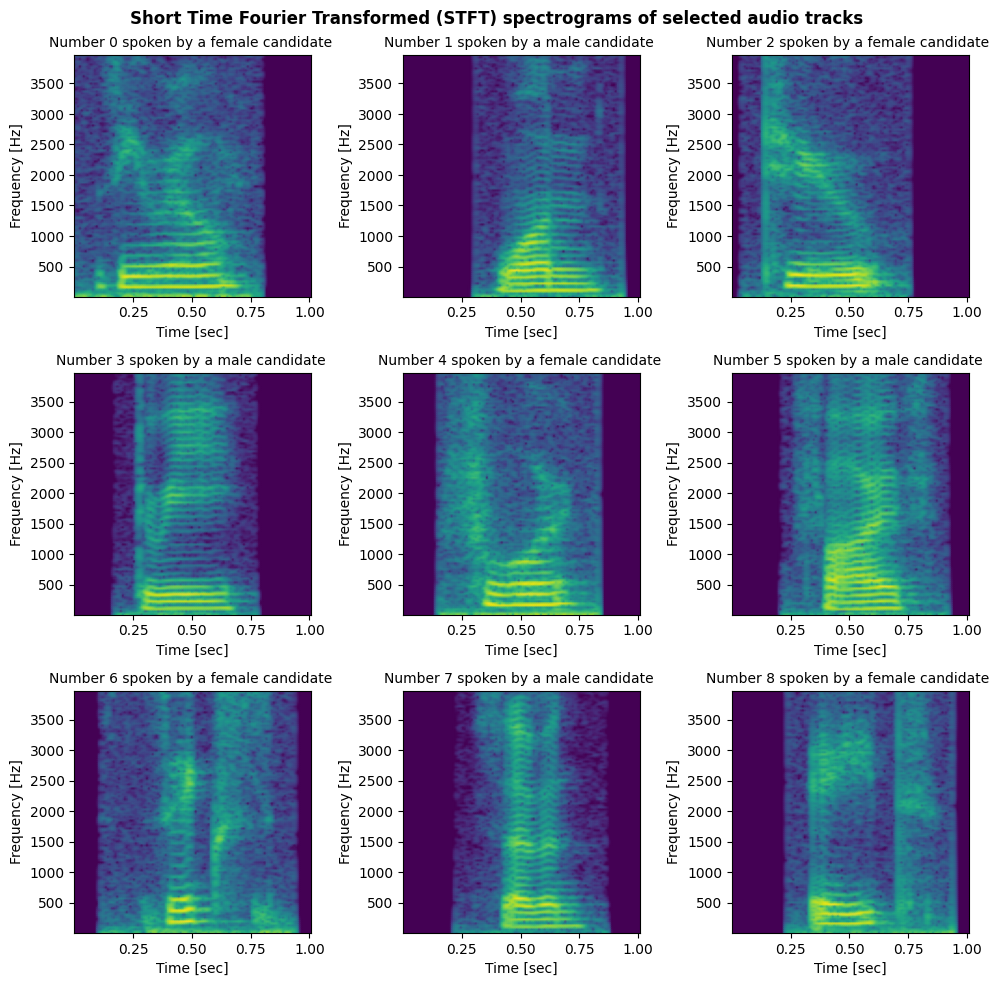

In [19]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # want to show different genders, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when tried to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

In [8]:
# Useful functions for model performance plots and logging. Also, to save the trained models for reuse.

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    if not os.path.exists("models"):
        os.makedirs("models")
        
    # save model and weights
    model_json = model.to_json()
    json_path = f"{filename_base}.json"
    weights_path = f"{filename_base}.weights.h5"
    with open(json_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print(f"Saved model to {json_path} and weights to {weights_path}")
    os.rename(json_path, os.path.join("models", json_path))
    os.rename(weights_path, os.path.join("models", weights_path))
    print(f"Moved the model to models/{filename_base}.json and its weights to models/{filename_base}.weights.h5")

### The problem

You have two tasks:

1. Train two neural nets taking in _raw waveforms_ and predicting either the digit or the gender. The input waveform should be treated as an 1-dimentional-list with a shape of (8000, 1). Individual models should be trained for each task listed below:

  - Task 1A. **Classification of Gender**: the output is a keras catergorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 1B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

2. Train the neural nets, this time taking the spectrograms as an input. This preprocessing step is commonly considered as a good embedding for representing the audio signal. The spectrograms should be standardised (through cropping) with a shape of [128, 128, 1] (see visualisation sample code above).

  - Task 2A. **Classification of Gender**: the output is a keras categorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 2B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

---

**IMPORTANT**

For Task 1A, your model should be saved and submitted with the name: **'waveform_gender_model'**

For Task 1B, your model should be saved and submitted with the name: **'waveform_digit_model'**

For Task 2A, your model should be saved and submitted with the name: **'spectrogram_gender_model'**

For Task 2B, your model should be saved and submitted with the name: **'spectrogram_digit_model'**

In [9]:
# Changing back to numpy arrays as raw waveforms are 1D arrays for mono-- the dataset provided was also np array.
x = x.reshape(x.shape[0], x.shape[1], 1)
x.shape, y_num.shape, y_gender.shape

((10800, 8000, 1), (10800,), (10800,))

In [22]:
print(f"{y_num[0]}, {y_gender[0]}")
Audio(x[0].squeeze(), rate = 8000)

0, 0


In [10]:
# Class weight computation for handling the imbalanced datase -x

class_weights = compute_class_weight("balanced", classes = np.unique(y_gender), y = y_gender)
class_wt_dict = dict(zip(np.unique(y_gender), class_weights))

In [24]:
X_train, X_valid, y_num_train, y_num_valid = train_test_split(x, y_num, test_size = 0.3, random_state = 0)
X_valid = X_valid.astype(np.float32) / 32768.0
_, _, y_gender_train, y_gender_valid = train_test_split(x, y_gender, test_size = 0.3, random_state = 0)
print(f"{X_train.shape, y_num_train.shape, y_gender_train.shape}")
print(f"{X_valid.shape, y_num_valid.shape, y_gender_valid.shape}")

((7560, 8000, 1), (7560,), (7560,))
((3240, 8000, 1), (3240,), (3240,))


In [25]:
print(f"{y_num_train[33]}, {y_gender_train[33]}")
Audio(X_train[33].squeeze(), rate = 8000)

9, 0


In [26]:
# Data Augmentation and processing for models

augment = Compose([
    AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.00115, p=0.9),
    TimeStretch(min_rate=0.9, max_rate=1.1, leave_length_unchanged=True, p=0.5),
    PitchShift(min_semitones=-2.0, max_semitones=2.0, p=0.5),
    Gain(min_gain_db=-6.0, max_gain_db=6.0, p=0.5)
])


shift_transform = Shift(min_shift = 0.25, max_shift = 0.35)

X_train_float = X_train.reshape(-1, 8000).astype(np.float32) / 32768.0

aug_index = np.random.choice(X_train_float.shape[0], size=3500, replace=False)
shift_index = np.random.choice(X_train_float.shape[0], size=3500, replace=False)

X_train_augmented_float = np.stack([augment(X_train_float[aug], sample_rate = 8000) for aug in aug_index])
X_train_shift_aug_float = np.stack([shift_transform(X_train_float[shift], sample_rate = 8000) for shift in shift_index])

y_num_aug = np.stack([y_num_train[aug] for aug in aug_index])
y_gender_aug = np.stack([y_gender_train[aug] for aug in aug_index])
y_num_shift = np.stack([y_num_train[shift] for shift in shift_index])
y_gender_shift = np.stack([y_gender_train[shift] for shift in shift_index])

X_train_concat_float = np.concatenate([X_train_float, X_train_augmented_float, X_train_shift_aug_float], axis = 0)

y_num_train_aug = np.concatenate([y_num_train, y_num_aug, y_num_shift], axis = 0)
y_gender_train_aug = np.concatenate([y_gender_train, y_gender_aug, y_gender_shift], axis = 0)

indices = np.arange(X_train_concat_float.shape[0])
np.random.shuffle(indices)

X_train_augmented = X_train_concat_float[indices]
y_num_train_augmented = y_num_train_aug[indices]
y_gender_train_augmented = y_gender_train_aug[indices]

X_train_augmented = X_train_augmented.reshape((X_train_augmented.shape[0], 8000, 1))
X_train_augmented.shape, y_num_train_augmented.shape, y_gender_train_augmented.shape

((14560, 8000, 1), (14560,), (14560,))

In [27]:
rndchc = np.random.choice(range(0, X_train_augmented.shape[0]))
print(f"{y_num_train_augmented[rndchc]}, {y_gender_train_augmented[rndchc]}")
Audio(X_train_augmented[rndchc].squeeze(), rate = 8000)

8, 0


In [28]:
Audio(X_train_augmented[rndchc+30].squeeze(), rate = 8000)

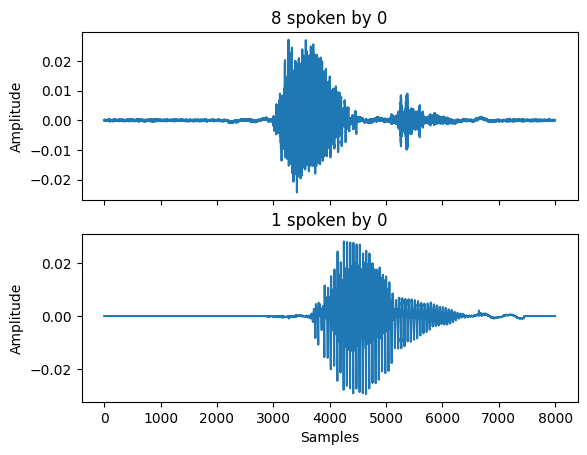

In [29]:
fig, ax = plt.subplots(2, sharex = True)
ax[0].plot(X_train_augmented[rndchc])
ax[0].set_title(f"{y_num_train_augmented[rndchc]} spoken by {y_gender_train_augmented[rndchc]}")
ax[0].set_ylabel("Amplitude")

ax[1].plot(X_train_augmented[rndchc + 30])
ax[1].set_title(f"{y_num_train_augmented[rndchc+30]} spoken by {y_gender_train_augmented[rndchc+30]}")
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Amplitude")

plt.show()

In [30]:
# Model definition for Classification over Raw Waveforms
# Implemented from the RESEARCH PAPER -- https://arxiv.org/pdf/1610.00087

def Model_18(num_classes):
    print("Using Model M18")
    m = Sequential()
    m.add(Input(shape=(8000, 1)))
    m.add(Conv1D(64, kernel_size=80, strides=4, padding="same", kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.L2(0.0001)))
    m.add(BatchNormalization())
    m.add(Activation("relu"))
    m.add(MaxPooling1D(pool_size=4, strides=None))

    for i in range(4):
        m.add(Conv1D(64, kernel_size=3, strides=1, padding="same", kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.L2(0.0001)))
        m.add(BatchNormalization())
        m.add(Activation("relu"))
    m.add(MaxPooling1D(pool_size=4, strides=None))

    for i in range(4):
        m.add(Conv1D(128, kernel_size=3, strides=1, padding="same", kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.L2(0.0001)))
        m.add(BatchNormalization())
        m.add(Activation("relu"))
    m.add(MaxPooling1D(pool_size=4, strides=None))

    for i in range(4):
        m.add(Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.L2(0.0001)))
        m.add(BatchNormalization())
        m.add(Activation("relu"))
    m.add(MaxPooling1D(pool_size=4, strides=None))

    for i in range(4):
        m.add(Conv1D(512, kernel_size=3, strides=1, padding="same", kernel_initializer="glorot_uniform",kernel_regularizer=regularizers.L2(0.0001)))
        m.add(BatchNormalization())
        m.add(Activation("relu"))

    m.add(GlobalAveragePooling1D())
    m.add(Dense(num_classes, activation="softmax"))

    return m

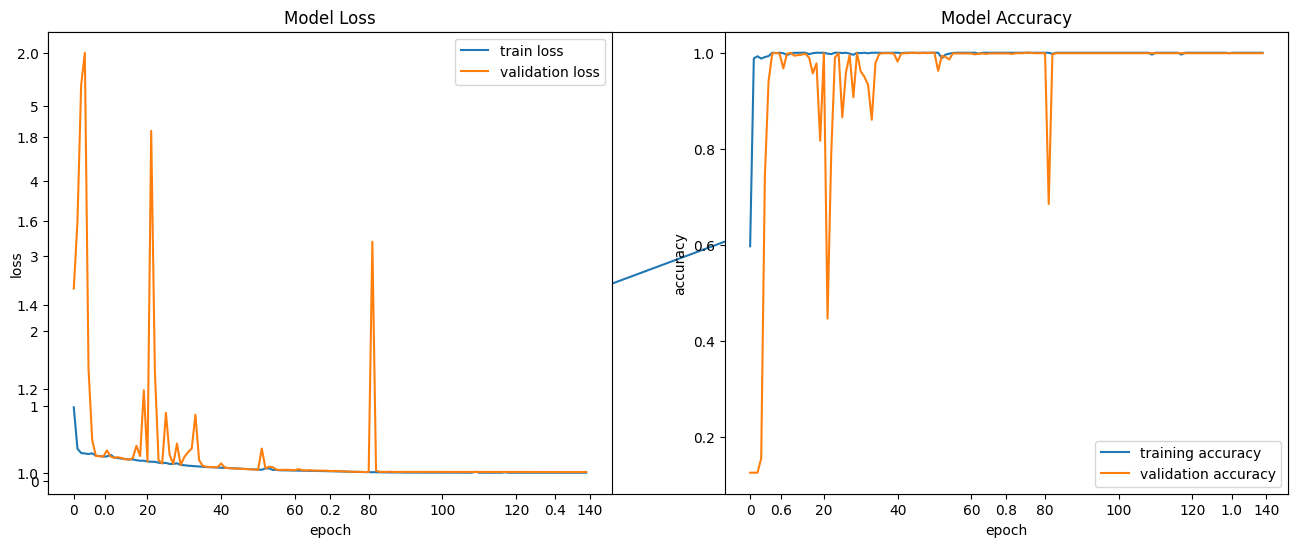


Epoch 140: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.

Epoch 140: val_accuracy did not improve from 0.99999
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 1.0000 - loss: 0.1052 - val_accuracy: 0.9990 - val_loss: 0.1145 - learning_rate: 1.2207e-08
Epoch 140: early stopping
Saved model to waveform_gender_model.json and weights to waveform_gender_model.weights.h5
Moved the model to models/waveform_gender_model.json and its weights to models/waveform_gender_model.weights.h5


In [31]:
# Task 1A: Gender Classisation on Waveforms

# Changed so for loading onto GPUs for distributed training
wave_train_gender = tf.data.Dataset.from_tensor_slices((X_train_augmented, y_gender_train_augmented))
wave_train_gender = wave_train_gender.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)

wave_val_gender = tf.data.Dataset.from_tensor_slices((X_valid, y_gender_valid))
wave_val_gender = wave_val_gender.batch(128).prefetch(tf.data.AUTOTUNE)

# Multi-GPU Distributed Training on single host -- synchronous
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices available: {strategy.num_replicas_in_sync}")

with strategy.scope():

    m18_1A = Model_18(2)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    m18_1A.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(m18_1A.summary())
    
    reduce_lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
    metrics = PlotLossAccuracy()
    earlystop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 60, verbose = 1)
    # chk_path = "/kaggle/working/models/checkpoints/wave_gen.weights.h5"
    chk_path = "/workspace/working/models/checkpoints/wave_gen.weights.h5"
    modelchkpt = keras.callbacks.ModelCheckpoint(filepath = chk_path, monitor = "val_accuracy", verbose = 1, mode = "max", save_best_only = True, save_freq = 'epoch')

    history = m18_1A.fit(wave_train_gender, epochs=400, verbose = "auto", validation_data = wave_val_gender, callbacks=[metrics, reduce_lr_scheduler, earlystop, modelchkpt], class_weight = class_wt_dict)

if (m18_1A.count_params()  < 4000000) :
  save_model_to_disk(m18_1A, 'waveform_gender_model')
else:
  print("Your model is unecessarily complex, scale down!")

In [32]:
Audio(x[0].squeeze(), rate = 8000)

In [11]:
# To ensure if the models saved correctly as well as predicitng to see if making predictions
# Also, reconstructed them as told above and for future reuse.
with open("models/waveform_gender_model.json", "r") as model:
  m18_1A_json = model.read()

m18_1A_reconst = model_from_json(m18_1A_json)
m18_1A_reconst.load_weights("models/waveform_gender_model.weights.h5")

print(m18_1A_reconst.summary())

print(m18_1A_reconst.predict(x[0].reshape(1, 8000, 1)))
print(np.argmax(m18_1A_reconst.predict(x[0].reshape(1, 8000, 1)), axis = 1))

I0000 00:00:1751764014.840064  154883 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22351 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1751764014.842507  154883 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22351 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2000, 64)       │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 125, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 125, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 125, 128)       │           51

 Total params: 7,367,174 (28.10 MB)

 Trainable params: 3,679,682 (14.04 MB)

 Non-trainable params: 7,808 (30.50 KB)

 Optimizer params: 3,679,684 (14.04 MB)

None


I0000 00:00:1751764017.980056  155354 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[1. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[0]


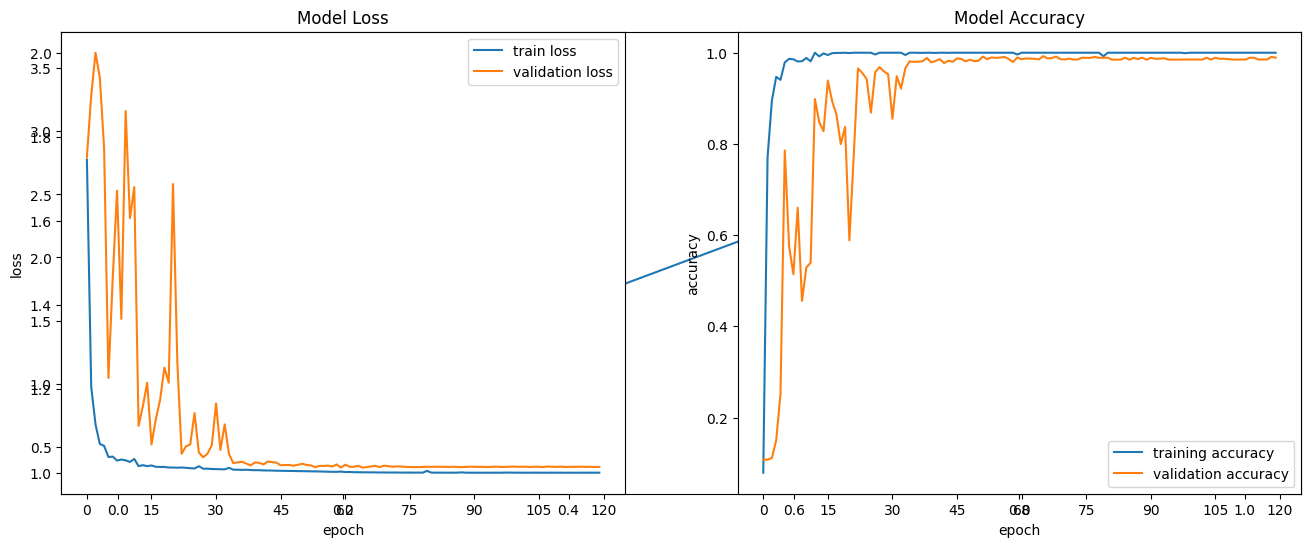


Epoch 120: ReduceLROnPlateau reducing learning rate to 7.629394338515283e-10.

Epoch 120: val_accuracy did not improve from 0.99247
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 1.0000 - loss: 0.2946 - val_accuracy: 0.9890 - val_loss: 0.3404 - learning_rate: 1.5259e-09
Epoch 120: early stopping
Saved model to waveform_num_model.json and weights to waveform_num_model.weights.h5
Moved the model to models/waveform_num_model.json and its weights to models/waveform_num_model.weights.h5


In [34]:
# Task 1B: Digit Classisation on Waveforms

wave_train_digit = tf.data.Dataset.from_tensor_slices((X_train_augmented, y_num_train_augmented))
wave_train_digit = wave_train_digit.shuffle(buffer_size = 1024).batch(128).prefetch(tf.data.AUTOTUNE)

wave_val_digit = tf.data.Dataset.from_tensor_slices((X_valid, y_num_valid))
wave_val_digit = wave_val_digit.batch(128).prefetch(tf.data.AUTOTUNE)

with strategy.scope():
    
    m18_1B = Model_18(10)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    m18_1B.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    print(m18_1B.summary())

    reduce_lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 1)
    metrics = PlotLossAccuracy()
    earlystop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 60, verbose = 1)
    # chk_path = "/kaggle/working/models/checkpoints/wave_num.weights.h5"
    chk_path = "/workspace/working/models/checkpoints/wave_num.weights.h5"
    modelchkpt = keras.callbacks.ModelCheckpoint(filepath = chk_path, monitor = "val_accuracy", verbose = 1, mode = "max", save_best_only = True, save_freq = 'epoch')

    history1 = m18_1B.fit(wave_train_digit, epochs = 400, verbose = "auto", validation_data = wave_val_digit, callbacks = [metrics, reduce_lr_scheduler, earlystop, modelchkpt])

if (m18_1B.count_params()  < 4000000) :
  save_model_to_disk(m18_1B, 'waveform_num_model')
else:
  print("Your model is unecessarily complex, scale down!")

In [12]:
with open("models/waveform_num_model.json", "r") as model:
  m18_1B_json = model.read()

m18_1B_reconst = model_from_json(m18_1B_json)
m18_1B_reconst.load_weights("models/waveform_num_model.weights.h5")

print(m18_1B_reconst.summary())

print(m18_1B_reconst.predict(x[0].reshape(1, 8000, 1)))
print(np.argmax(m18_1B_reconst.predict(x[0].reshape(1, 8000, 1)), axis = 1))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 2000, 64)       │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 2000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 125, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 125, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 125, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 125, 128)       │           51

 Total params: 7,375,382 (28.13 MB)

 Trainable params: 3,683,786 (14.05 MB)

 Non-trainable params: 7,808 (30.50 KB)

 Optimizer params: 3,683,788 (14.05 MB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[4]


In [13]:
# For clearing any memory taken by the variables, models and all above seen in the GPU for easier future work done on GPU by avoiding overflow.

tf.keras.backend.clear_session()
gc.collect()

0

In [14]:
# For easier data augmentation over spectrograms using Tensorflow

x_tensor = tf.convert_to_tensor(x.astype(np.float32) / 32768.0, dtype = tf.float32)
Audio(tf.squeeze(x_tensor[0]), rate = 8000)

In [ ]:
# Done for deleting unwanted variables to free up memory so that the ernel does not crash due to memory overflow or similar issues.

del x
del temp
del classes
del counts
del X_train
del X_valid
del y_num_train
del y_gender_valid
del y_gender_train
del augment
del aug_index
del shift_index
del y_num_aug
del y_gender_aug
del y_num_shift
del y_gender_shift
del X_train_shift_aug_float
del X_train_float
del X_train_augmented_float
del X_train_concat_float
del y_num_train_aug
del y_gender_train_aug
del indices
del X_train_augmented
del y_num_train_augmented
del y_gender_train_augmented
del fig
del ax
del wave_train_gender
del wave_val_gender
del wave_train_digit
del wave_val_digit
gc.collect()

0

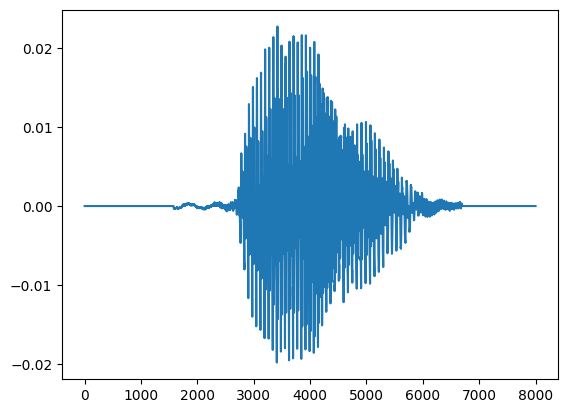

In [38]:
# Just like that -- sanity check and yes.

plt.plot(x_tensor[0])
plt.show()

In [16]:
def spectrogram_generator(audio_array):
    f, t, Zxx_spect = scipy.signal.stft(audio_array.reshape((8000,)), 8000, nperseg = 455, noverlap = 393, window = "hann")
    Zxx_mag = np.abs(Zxx_spect)
    Zxx_mag = np.atleast_3d(Zxx_mag)
    return Zxx_mag, f, t

In [17]:
# Conversion to spectrograms of the raw audio waveforms for training of spectrogram-based models

freqs = []
times = []
x_spectrograms = []

with ProcessPoolExecutor(max_workers = cpu_count()) as executor:
    futures = list(executor.map(spectrogram_generator, x_tensor.numpy()))

for future in tqdm(futures):
    x_spectrograms.append(future[0])
    freqs.append(future[1])
    times.append(future[2])

x_spectrograms = tf.convert_to_tensor(x_spectrograms, dtype = tf.float32)

x_spectrograms

  0%|          | 0/10800 [00:00<?, ?it/s]

<tf.Tensor: shape=(10800, 228, 131, 1), dtype=float32, numpy=
array([[[[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        ...,

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.

(10800, 228, 131, 1)
(228, 131, 1)
0, 0


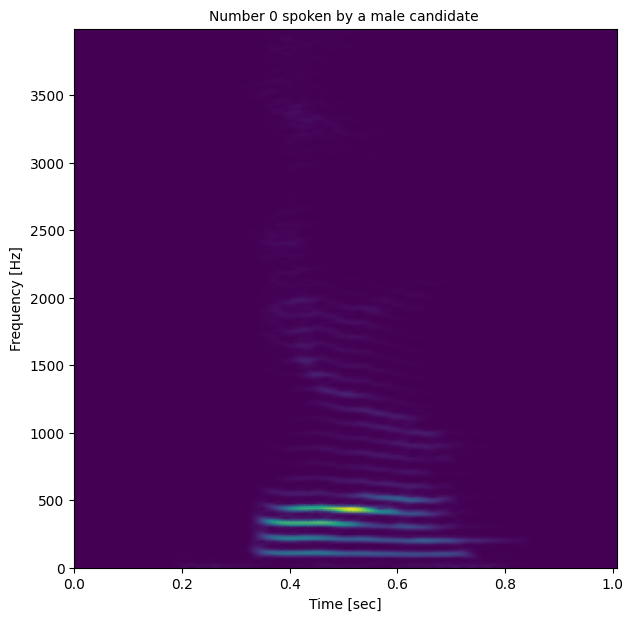

In [18]:
print(x_spectrograms.shape)
print(x_spectrograms[0].shape)
print(f"{y_gender[0]}, {y_num[0]}")
xt = x_spectrograms[0]
fig, ax = plt.subplots(figsize=(7, 7))
num_speak = y_num[0]
gender_spoke = y_gender[0]
gender_spoke = 'male' if gender_spoke == 0 else 'female'
ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
ax.pcolormesh(times[0], freqs[0], xt[:, :, 0], shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.show()

In [19]:
del freqs
del times
gc.collect()

30

In [20]:
# For the creation of log mel spectrograms which approximate the way sound is perceived by the human ear and are more human-interpretable.

mel_spectrograms = []

for wave in tqdm(x_spectrograms):
    mel = tfio.audio.melscale(tf.squeeze(wave), rate=8000, mels=128, fmin=0, fmax=4000)
    mel_spectrograms.append(mel)

mel_spectrograms = tf.stack(mel_spectrograms)

mel_spectrograms

  0%|          | 0/10800 [00:00<?, ?it/s]

<tf.Tensor: shape=(10800, 228, 128), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.48392049e-05, 7.71777559e-05, 1.18276424e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.93775006e-04,

In [21]:
# A small number addition for numerical stability. Avoiding log of zero.

log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
log_mel_spectrograms

<tf.Tensor: shape=(10800, 228, 128), dtype=float32, numpy=
array([[[-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ],
        [-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ],
        [-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ],
        ...,
        [-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ],
        [-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ],
        [-13.815511 , -13.815511 , -13.815511 , ..., -13.815511 ,
         -13.815511 , -13.815511 ]],

       [[-13.815511 , -13.815511 , -13.815511 , ...,  -9.486896 ,
          -9.456526 ,  -9.034067 ],
        [-13.815511 , -13.815511 , -13.815511 , ...,  -8.543666 ,
          -8.52711  ,  -8.77401  ],
        [-13.815511 , -13.815511 , -13.815511 , ...,  -8.901058 ,
          -8.731426 ,  -9.08744  ],
        

In [22]:
# Used dB scaling as to match the human perception of sound i.e., loundness and more robustness in training.

dbscale_mel_spectrograms = tfio.audio.dbscale(log_mel_spectrograms, top_db=80)
dbscale_mel_spectrograms

<tf.Tensor: shape=(10800, 228, 128), dtype=float32, numpy=
array([[[22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ],
        [22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ],
        [22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ],
        ...,
        [22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ],
        [22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ],
        [22.80734 , 22.80734 , 22.80734 , ..., 22.80734 , 22.80734 ,
         22.80734 ]],

       [[22.80734 , 22.80734 , 22.80734 , ..., 19.542482, 19.514633,
         19.117664],
        [22.80734 , 22.80734 , 22.80734 , ..., 18.632885, 18.616035,
         18.863962],
        [22.80734 , 22.80734 , 22.80734 , ..., 18.988832, 18.821705,
         19.16883 ],
        ...,
        [22.80734 , 22.80734 , 22.80734 , ..., 21.187798, 21.667595,
         22.165422],
        [22.8

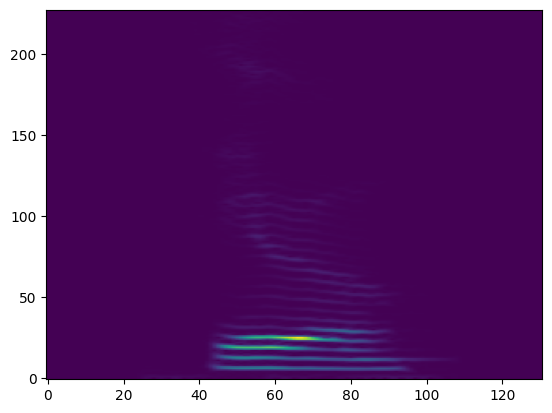

In [23]:
plt.figure()
plt.imshow(x_spectrograms[0].numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.show()

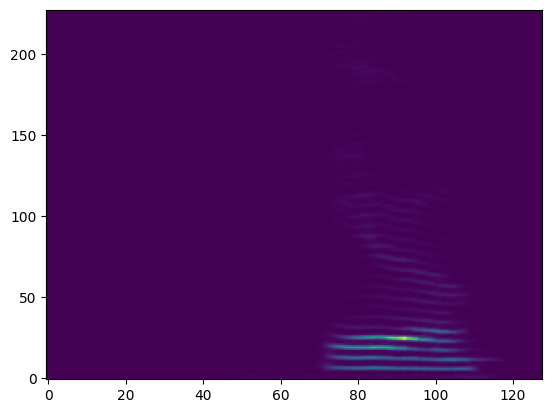

In [24]:
plt.figure()
plt.imshow(mel_spectrograms[0].numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.show()

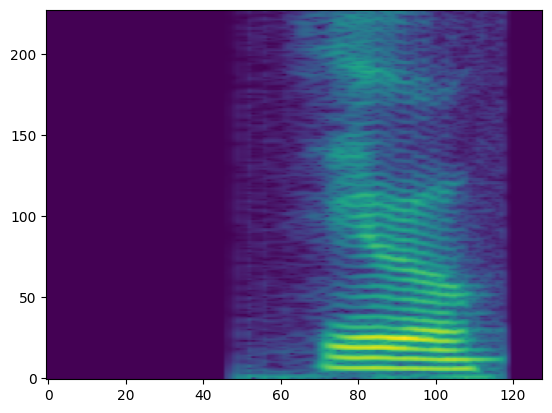

In [25]:
plt.figure()
plt.imshow(log_mel_spectrograms[0].numpy(), origin='lower', aspect='auto', cmap='viridis')

plt.show()

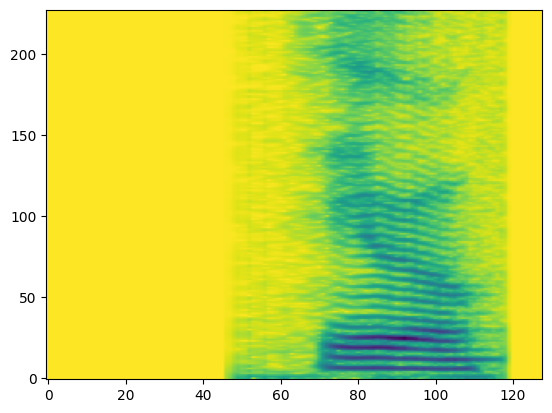

In [26]:
plt.figure()
plt.imshow(dbscale_mel_spectrograms[0].numpy(), origin='lower', aspect='auto', cmap='viridis')

plt.show()

In [27]:
X_spectrograms_np, X_spectrograms_valid_np, y_num_np, y_num_valid_np = train_test_split(dbscale_mel_spectrograms.numpy(), y_num, test_size = 0.3, random_state = 0)
_, _, y_gender_np, y_gender_valid_np = train_test_split(dbscale_mel_spectrograms.numpy(), y_gender, test_size = 0.3, random_state = 0)

In [28]:
X_spectrograms_train = tf.reshape(tf.convert_to_tensor(X_spectrograms_np), (X_spectrograms_np.shape[0], X_spectrograms_np.shape[1], X_spectrograms_np.shape[2], 1))
X_spectrograms_valid = tf.reshape(tf.convert_to_tensor(X_spectrograms_valid_np), (X_spectrograms_valid_np.shape[0], X_spectrograms_valid_np.shape[1], X_spectrograms_valid_np.shape[2], 1))
y_num_train = tf.convert_to_tensor(y_num_np, dtype = tf.int16)
y_num_valid = tf.convert_to_tensor(y_num_valid_np, dtype = tf.int16)
y_gender_train = tf.convert_to_tensor(y_gender_np, dtype = tf.int16)
y_gender_valid = tf.convert_to_tensor(y_gender_valid_np, dtype = tf.int16)

print(f"{X_spectrograms_train.shape, y_num_train.shape, y_gender_train.shape}")
print(f"{X_spectrograms_valid.shape, y_num_valid.shape, y_gender_valid.shape}")

(TensorShape([7560, 228, 128, 1]), TensorShape([7560]), TensorShape([7560]))
(TensorShape([3240, 228, 128, 1]), TensorShape([3240]), TensorShape([3240]))


In [29]:
# Data Augmentation over Spectrograms using the SpecAugment through Tensorflow
# Reference Research Paper: https://arxiv.org/pdf/1904.08779

X_spectrograms_freq_mask = []
X_spectrograms_time_mask = []

index = np.random.choice(X_spectrograms_train.shape[0], size=3500, replace=False)

for spect in tqdm(index):
    X_spectrograms_freq_mask.append(tfio.audio.freq_mask(tf.squeeze(X_spectrograms_train[spect]), param = 10))
    X_spectrograms_time_mask.append(tfio.audio.time_mask(tf.squeeze(X_spectrograms_train[spect]), param = 10))

X_spectrograms_freq_mask = tf.convert_to_tensor(X_spectrograms_freq_mask)
X_spectrograms_time_mask = tf.convert_to_tensor(X_spectrograms_time_mask)

X_spectrograms_freq_mask = tf.reshape(X_spectrograms_freq_mask, (X_spectrograms_freq_mask.shape[0], X_spectrograms_freq_mask.shape[1], X_spectrograms_freq_mask.shape[2], 1))
X_spectrograms_time_mask = tf.reshape(X_spectrograms_time_mask, (X_spectrograms_freq_mask.shape[0], X_spectrograms_freq_mask.shape[1], X_spectrograms_freq_mask.shape[2], 1))

y_num_train_freq_time = tf.convert_to_tensor([y_num_train[i] for i in index])
y_gender_train_freq_time = tf.convert_to_tensor([y_gender_train[i] for i in index])

X_spectrograms_train_augmented = tf.concat([X_spectrograms_train, X_spectrograms_freq_mask, X_spectrograms_time_mask], axis = 0)
y_spectrograms_num_train_augmented = tf.concat([y_num_train, y_num_train_freq_time, y_num_train_freq_time], axis = 0)
y_spectrograms_gender_train_augmented = tf.concat([y_gender_train, y_gender_train_freq_time, y_gender_train_freq_time], axis = 0)

print(f"{X_spectrograms_train_augmented.shape}, {y_spectrograms_num_train_augmented.shape}, {y_spectrograms_gender_train_augmented.shape}")

  0%|          | 0/3500 [00:00<?, ?it/s]

(14560, 228, 128, 1), (14560,), (14560,)


In [30]:
del mel_spectrograms
del log_mel_spectrograms
gc.collect()

7048

In [31]:
# Shuffling of the data ready for the models to avoid bias and have more randomness.

indices = tf.range(14560)
indices = tf.random.shuffle(indices)

with tf.device('/CPU:0'):
    X_spectrograms_train_augmented = tf.gather(X_spectrograms_train_augmented, indices)
    y_spectrograms_num_train_augmented = tf.gather(y_spectrograms_num_train_augmented, indices)
    y_spectrograms_gender_train_augmented = tf.gather(y_spectrograms_gender_train_augmented, indices)

X_train_np = X_spectrograms_train_augmented.numpy()
X_valid_np = X_spectrograms_valid.numpy()

X_train_resized = resize(X_train_np, (X_train_np.shape[0], 128, 128, 1), preserve_range=True, anti_aliasing=True)
X_valid_resized = resize(X_valid_np, (X_valid_np.shape[0], 128, 128, 1), preserve_range=True, anti_aliasing=True)

X_spectrograms_train_augmented = tf.convert_to_tensor(X_train_resized, dtype=tf.float32)
X_spectrograms_valid = tf.convert_to_tensor(X_valid_resized, dtype=tf.float32)

print(f"{X_spectrograms_train_augmented.shape, y_spectrograms_num_train_augmented.shape, y_spectrograms_gender_train_augmented.shape}")
print(f"{X_spectrograms_valid.shape, y_num_valid.shape, y_gender_valid.shape}")

(TensorShape([14560, 128, 128, 1]), TensorShape([14560]), TensorShape([14560]))
(TensorShape([3240, 128, 128, 1]), TensorShape([3240]), TensorShape([3240]))


In [32]:
tf.keras.backend.clear_session()
gc.collect()

0

In [33]:
del x_copy
del y_gender_copy
del y_num_copy
del y_num
del y_gender
del x_spectrograms
del X_spectrograms_train
del X_train_np
del X_valid_np
del X_train_resized
del X_valid_resized
del y_num_train
del y_gender_train
del X_spectrograms_freq_mask
del X_spectrograms_time_mask
del indices
del y_num_train_freq_time
del y_gender_train_freq_time
del X_spectrograms_np
del X_spectrograms_valid_np
del y_num_np
del y_num_valid_np
del y_gender_np
del y_gender_valid_np
gc.collect()

0

In [34]:
# Spectrogram inputs based Deep Learning model - CNN based

def spectrogram_model(num_classes):

  m = Sequential()
  m.add(Input(shape = (128, 128, 1)))

  m.add(Conv2D(32, 3, strides = 2, padding = "same"))
  m.add(BatchNormalization())
  m.add(Activation("relu"))
  m.add(MaxPooling2D(pool_size = 2))
  m.add(BatchNormalization())

  m.add(Conv2D(64, 3, padding = "same"))
  m.add(BatchNormalization())
  m.add(Activation("relu"))
  m.add(MaxPooling2D(pool_size = 2))
  m.add(BatchNormalization())

  m.add(Conv2D(128, 3, padding = "same"))
  m.add(BatchNormalization())
  m.add(Activation("relu"))
  m.add(MaxPooling2D(pool_size = 2))
  m.add(BatchNormalization())

  m.add(Conv2D(128, 2, padding = "same"))
  m.add(BatchNormalization())
  m.add(Activation("relu"))
  m.add(MaxPooling2D(pool_size = 1))
  m.add(BatchNormalization())

  m.add(Flatten())
  m.add(Dense(256, activation = "relu"))
  m.add(BatchNormalization())
  m.add(Dropout(0.5))

  m.add(Dense(num_classes, activation = "softmax"))

  return m

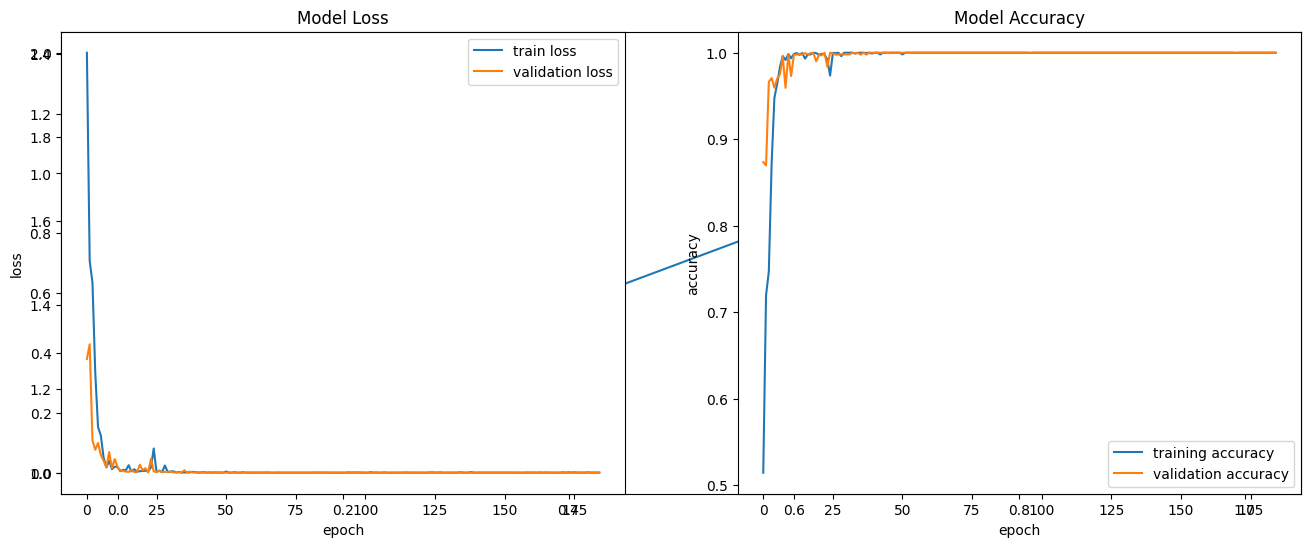


Epoch 185: val_accuracy did not improve from 0.99999
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 1.0000 - loss: 6.5530e-04 - val_accuracy: 1.0000 - val_loss: 3.2535e-04 - learning_rate: 9.3132e-14
Epoch 185: early stopping
Saved model to spectrogram_gender_model.json and weights to spectrogram_gender_model.weights.h5
Moved the model to models/spectrogram_gender_model.json and its weights to models/spectrogram_gender_model.weights.h5


In [35]:
# Task 2A: Gender Classisation on Spectrograms\

spectrogram_train_gender = tf.data.Dataset.from_tensor_slices((X_spectrograms_train_augmented, y_spectrograms_gender_train_augmented))
spectrogram_train_gender = spectrogram_train_gender.shuffle(buffer_size = 1024).batch(128).prefetch(tf.data.AUTOTUNE)

spectrogram_val_gender = tf.data.Dataset.from_tensor_slices((X_spectrograms_valid, y_gender_valid))
spectrogram_val_gender = spectrogram_val_gender.batch(128).prefetch(tf.data.AUTOTUNE)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model_2A = spectrogram_model(2)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model_2A.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    print(model_2A.summary())

    reduce_lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 1)
    metrics_spectrogram = PlotLossAccuracy()
    earlystop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 60, verbose = 1)
    # chk_path = "/kaggle/working/models/checkpoints/spectrogram_gender.weights.h5"
    chk_path = "/workspace/working/models/checkpoints/spectrogram_gender.weights.h5"
    modelchkpt = keras.callbacks.ModelCheckpoint(filepath = chk_path, monitor = "val_accuracy", verbose = 1, mode = "max", save_best_only = True, save_freq = 'epoch')

    history2 = model_2A.fit(spectrogram_train_gender, epochs=300, verbose = "auto", validation_data = spectrogram_val_gender, callbacks=[metrics_spectrogram, reduce_lr_scheduler, earlystop, modelchkpt])

if (model_2A.count_params()  < 4000000) :
  save_model_to_disk(model_2A, 'spectrogram_gender_model')
else:
  print("Your model is unecessarily complex, scale down!")

In [36]:
with open("models/spectrogram_gender_model.json", "r") as model:
  m_2A_json = model.read()

m_2A_reconst = model_from_json(m_2A_json)
m_2A_reconst.load_weights("models/spectrogram_gender_model.weights.h5")

print(m_2A_reconst.summary())

print(m_2A_reconst.predict(tf.reshape(resize(dbscale_mel_spectrograms[0], (128, 128, 1)), (1, 128, 128, 1))))
print(np.argmax(m_2A_reconst.predict(tf.reshape(resize(dbscale_mel_spectrograms[0], (128, 128, 1)), (1, 128, 128, 1))), axis = 1))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             

 Total params: 4,518,278 (17.24 MB)

 Trainable params: 2,258,178 (8.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,258,180 (8.61 MB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[[9.999020e-01 9.801825e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[0]


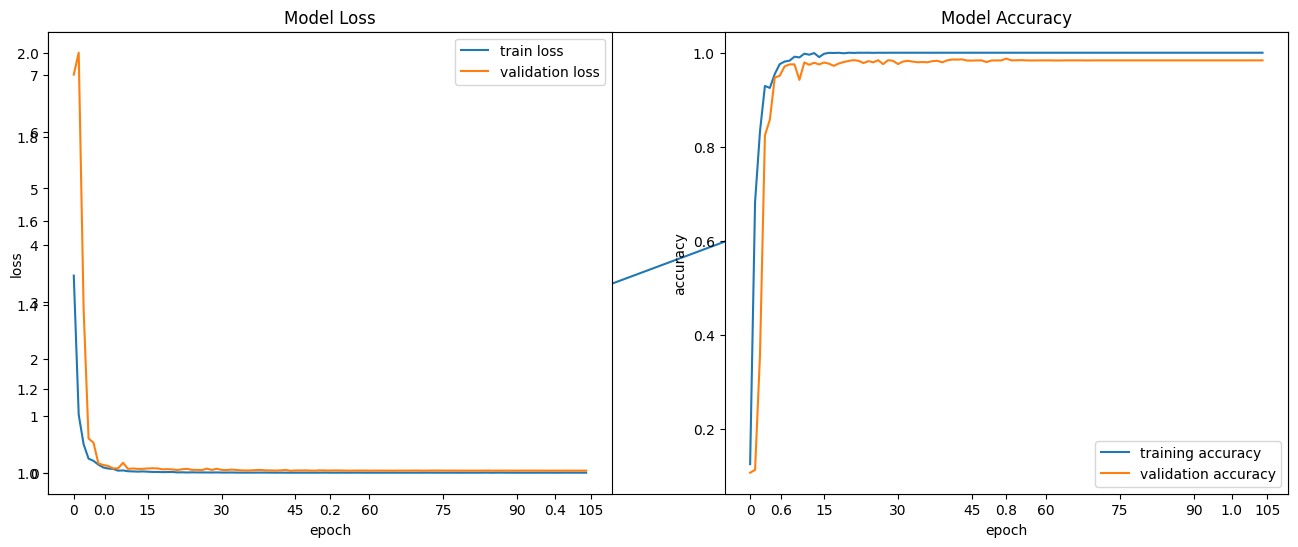


Epoch 105: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.

Epoch 105: val_accuracy did not improve from 0.98764
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9837 - val_loss: 0.0373 - learning_rate: 1.2207e-08
Epoch 105: early stopping
Saved model to spectrogram_num_model.json and weights to spectrogram_num_model.weights.h5
Moved the model to models/spectrogram_num_model.json and its weights to models/spectrogram_num_model.weights.h5


In [37]:
# Task 2B: Digit Classisation on Spectrograms

spectrogram_train_digit = tf.data.Dataset.from_tensor_slices((X_spectrograms_train_augmented, y_spectrograms_num_train_augmented))
spectrogram_train_digit = spectrogram_train_digit.shuffle(buffer_size = 1024).batch(128).prefetch(tf.data.AUTOTUNE)

spectrogram_val_digit = tf.data.Dataset.from_tensor_slices((X_spectrograms_valid, y_num_valid))
spectrogram_val_digit = spectrogram_val_digit.batch(128).prefetch(tf.data.AUTOTUNE)

with strategy.scope():
    
    model_2B = spectrogram_model(10)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model_2B.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    print(model_2B.summary())

    reduce_lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 1)
    metrics_spectrogram = PlotLossAccuracy()
    earlystop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 60, verbose = 1)
    # chk_path = "/kaggle/working/models/checkpoints/spectrogram_num.weights.h5"
    chk_path = "/workspace/working/models/checkpoints/spectrogram_num.weights.h5"
    modelchkpt = keras.callbacks.ModelCheckpoint(filepath = chk_path, monitor = "val_accuracy", verbose = 1, mode = "max", save_best_only = True, save_freq = 'epoch')

    history3 = model_2B.fit(spectrogram_train_digit, epochs=300, verbose = "auto", validation_data = spectrogram_val_digit, callbacks=[metrics_spectrogram, reduce_lr_scheduler, earlystop, modelchkpt])

if (model_2B.count_params()  < 4000000) :
  save_model_to_disk(model_2B, 'spectrogram_num_model')
else:
  print("Your model is unecessarily complex, scale down!")

In [38]:
with open("models/spectrogram_num_model.json", "r") as model:
  m_2B_json = model.read()

m_2B_reconst = model_from_json(m_2B_json)
m_2B_reconst.load_weights("models/spectrogram_num_model.weights.h5")

m_2B_reconst.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
print(m_2B_reconst.summary())

print(m_2B_reconst.predict(tf.reshape(resize(dbscale_mel_spectrograms[0], (128, 128, 1)), (1, 128, 128, 1))))
print(np.argmax(m_2B_reconst.predict(tf.reshape(resize(dbscale_mel_spectrograms[0], (128, 128, 1)), (1, 128, 128, 1))),  axis = 1))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             

 Total params: 2,262,154 (8.63 MB)

 Trainable params: 2,260,234 (8.62 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


I0000 00:00:1751767129.488589  155352 service.cc:148] XLA service 0x55856f3f4c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751767129.488691  155352 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1751767129.488849  155352 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-06 01:58:49.513603: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[[9.9997652e-01 1.6250067e-06 1.5248727e-05 2.6614788e-10 5.8225869e-06
  1.3287536e-09 5.6542618e-08 8.4335234e-08 5.7614510e-08 5.8620651e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


I0000 00:00:1751767130.205120  155352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[0]


In [39]:
del class_weights
del class_wt_dict
del X_spectrograms_valid
del y_gender_valid
del y_num_valid
del X_spectrograms_train_augmented
del y_spectrograms_num_train_augmented
del y_spectrograms_gender_train_augmented
del spectrogram_train_digit
del spectrogram_train_gender
del dbscale_mel_spectrograms
gc.collect()

112535

In [40]:
tf.keras.backend.clear_session()
gc.collect()

0

In [41]:
# %ls
# %cd /kaggle/working/models/
# %ls
# %cd /kaggle/working/models/checkpoints/
%cd /workspace/working/models/checkpoints/
%ls
%cd ../
%cd ../
%pwd

/workspace/working/models/checkpoints
spectrogram_gender.weights.h5  wave_gen.weights.h5
spectrogram_num.weights.h5     wave_num.weights.h5
/workspace/working/models
/workspace/working


'/workspace/working'

In [42]:
# audio-mnist is the test set to check the performance of all the models.
# Obviously, it is not from the same distrbution as are the train and validation sets for the models.
# This dataset will also be considered as the benchmark for these models. Consequently, comparative study based results will be inferred.
# https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist/data
# In the following cells, some basic data shifting within directories, preprocessing of the audio to the required inputs for the models -- 
# raw waveforms (8kHz) and spectrograms -- and all is done. Quite easy to understand.

# Download latest version
path = kagglehub.dataset_download("sripaadsrinivasan/audio-mnist")

print("Path to dataset files:", path)

# !cp -r /kaggle/input/audio-mnist/ /kaggle/working/audio_data_test_benchmark_unzipped/
!cp -r /root/.cache/kagglehub/datasets/sripaadsrinivasan/audio-mnist/versions/1 /workspace/working/audio_data_test_benchmark_unzipped/

100%|██████████| 948M/948M [00:49<00:00, 20.0MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sripaadsrinivasan/audio-mnist/versions/1


In [43]:
# %cd /kaggle/working/audio_data_test_benchmark_unzipped/data/
%cd /workspace/working/audio_data_test_benchmark_unzipped/data/
!mv * ../

/workspace/working/audio_data_test_benchmark_unzipped/data


In [44]:
%cd ../
%ls

/workspace/working/audio_data_test_benchmark_unzipped
01/  06/  11/  16/  21/  26/  31/  36/  41/  46/  51/  56/  audioMNIST_meta.txt
02/  07/  12/  17/  22/  27/  32/  37/  42/  47/  52/  57/  data/
03/  08/  13/  18/  23/  28/  33/  38/  43/  48/  53/  58/
04/  09/  14/  19/  24/  29/  34/  39/  44/  49/  54/  59/
05/  10/  15/  20/  25/  30/  35/  40/  45/  50/  55/  60/


In [45]:
!rmdir data

In [46]:
%ls

01/  06/  11/  16/  21/  26/  31/  36/  41/  46/  51/  56/  audioMNIST_meta.txt
02/  07/  12/  17/  22/  27/  32/  37/  42/  47/  52/  57/
03/  08/  13/  18/  23/  28/  33/  38/  43/  48/  53/  58/
04/  09/  14/  19/  24/  29/  34/  39/  44/  49/  54/  59/
05/  10/  15/  20/  25/  30/  35/  40/  45/  50/  55/  60/


In [47]:
# %cd /kaggle/working/audio_data_test_benchmark_unzipped/01/
%cd /workspace/working/audio_data_test_benchmark_unzipped/01/
%ls

/workspace/working/audio_data_test_benchmark_unzipped/01
0_01_0.wav   1_01_4.wav   3_01_25.wav  5_01_10.wav  6_01_41.wav  8_01_27.wav
0_01_1.wav   1_01_40.wav  3_01_26.wav  5_01_11.wav  6_01_42.wav  8_01_28.wav
0_01_10.wav  1_01_41.wav  3_01_27.wav  5_01_12.wav  6_01_43.wav  8_01_29.wav
0_01_11.wav  1_01_42.wav  3_01_28.wav  5_01_13.wav  6_01_44.wav  8_01_3.wav
0_01_12.wav  1_01_43.wav  3_01_29.wav  5_01_14.wav  6_01_45.wav  8_01_30.wav
0_01_13.wav  1_01_44.wav  3_01_3.wav   5_01_15.wav  6_01_46.wav  8_01_31.wav
0_01_14.wav  1_01_45.wav  3_01_30.wav  5_01_16.wav  6_01_47.wav  8_01_32.wav
0_01_15.wav  1_01_46.wav  3_01_31.wav  5_01_17.wav  6_01_48.wav  8_01_33.wav
0_01_16.wav  1_01_47.wav  3_01_32.wav  5_01_18.wav  6_01_49.wav  8_01_34.wav
0_01_17.wav  1_01_48.wav  3_01_33.wav  5_01_19.wav  6_01_5.wav   8_01_35.wav
0_01_18.wav  1_01_49.wav  3_01_34.wav  5_01_2.wav   6_01_6.wav   8_01_36.wav
0_01_19.wav  1_01_5.wav   3_01_35.wav  5_01_20.wav  6_01_7.wav   8_01_37.wav
0_01_2.wav   1_01_6.

In [48]:
%cd ../

/workspace/working/audio_data_test_benchmark_unzipped


In [49]:
%ls

01/  06/  11/  16/  21/  26/  31/  36/  41/  46/  51/  56/  audioMNIST_meta.txt
02/  07/  12/  17/  22/  27/  32/  37/  42/  47/  52/  57/
03/  08/  13/  18/  23/  28/  33/  38/  43/  48/  53/  58/
04/  09/  14/  19/  24/  29/  34/  39/  44/  49/  54/  59/
05/  10/  15/  20/  25/  30/  35/  40/  45/  50/  55/  60/


In [50]:
!cat audioMNIST_meta.txt

{
    "01": {
        "accent": "german", 
        "age": 30, 
        "gender": "male", 
        "native speaker": "no", 
        "origin": "Europe, Germany, Wuerzburg", 
        "recordingdate": "17-06-22-11-04-28", 
        "recordingroom": "Kino"
    }, 
    "02": {
        "accent": "German", 
        "age": "25", 
        "gender": "male", 
        "native speaker": "no", 
        "origin": "Europe, Germany, Hamburg", 
        "recordingdate": "17-06-26-17-57-29", 
        "recordingroom": "Kino"
    }, 
    "03": {
        "accent": "German", 
        "age": "31", 
        "gender": "male", 
        "native speaker": "no", 
        "origin": "Europe, Germany, Bremen", 
        "recordingdate": "17-06-30-17-34-51", 
        "recordingroom": "Kino"
    }, 
    "04": {
        "accent": "German", 
        "age": "23", 
        "gender": "male", 
        "native speaker": "no", 
        "origin": "Europe, Germany, Helmstedt", 
        "recordingdate": "17-06-30-18-09-14", 
        "

In [51]:
# with open('/kaggle/working/audio_data_test_benchmark_unzipped/audioMNIST_meta.txt', "r") as audioMNIST_meta:
with open('/workspace/working/audio_data_test_benchmark_unzipped/audioMNIST_meta.txt', "r") as audioMNIST_meta:
  audioMNIST_metadata = json.load(audioMNIST_meta)
print(type(audioMNIST_metadata))
audioMNIST_metadata.keys()

<class 'dict'>


dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60'])

In [52]:
for i in tqdm(range(1, 61)):
  if i < 10:
    folder = f"0{i}"
    !mv {folder}/* .
  else:
    folder = f"{i}"
    !mv {folder}/* .

  0%|          | 0/60 [00:00<?, ?it/s]

In [53]:
# base_path = '/kaggle/working/audio_data_test_benchmark_unzipped/'
base_path = '/workspace/working/audio_data_test_benchmark_unzipped/'

# List only directories (exclude files)
only_dirs = [dir for dir in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, dir))]
print(only_dirs)

# List only empty directories
empty_dirs = []
for dir in only_dirs:
    if not os.listdir(os.path.join(base_path, dir)):
      empty_dirs.append(dir)
print(empty_dirs)

# Remove the empty directories
for dir in empty_dirs:
    os.rmdir(os.path.join(base_path, dir))

total_files = 0
for file in os.listdir(base_path):
  if file == "audioMNIST_meta.txt":
    continue
  if os.path.isfile(os.path.join(base_path, file)):
    total_files += 1
print(total_files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
30000


In [54]:
only_dirs = [dir for dir in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, dir))]
print(only_dirs)

[]


In [55]:
%ls

0_01_0.wav   2_01_1.wav   4_01_10.wav  6_01_11.wav  8_01_12.wav
0_01_1.wav   2_01_10.wav  4_01_11.wav  6_01_12.wav  8_01_13.wav
0_01_10.wav  2_01_11.wav  4_01_12.wav  6_01_13.wav  8_01_14.wav
0_01_11.wav  2_01_12.wav  4_01_13.wav  6_01_14.wav  8_01_15.wav
0_01_12.wav  2_01_13.wav  4_01_14.wav  6_01_15.wav  8_01_16.wav
0_01_13.wav  2_01_14.wav  4_01_15.wav  6_01_16.wav  8_01_17.wav
0_01_14.wav  2_01_15.wav  4_01_16.wav  6_01_17.wav  8_01_18.wav
0_01_15.wav  2_01_16.wav  4_01_17.wav  6_01_18.wav  8_01_19.wav
0_01_16.wav  2_01_17.wav  4_01_18.wav  6_01_19.wav  8_01_2.wav
0_01_17.wav  2_01_18.wav  4_01_19.wav  6_01_2.wav   8_01_20.wav
0_01_18.wav  2_01_19.wav  4_01_2.wav   6_01_20.wav  8_01_21.wav
0_01_19.wav  2_01_2.wav   4_01_20.wav  6_01_21.wav  8_01_22.wav
0_01_2.wav   2_01_20.wav  4_01_21.wav  6_01_22.wav  8_01_23.wav
0_01_20.wav  2_01_21.wav  4_01_22.wav  6_01_23.wav  8_01_24.wav
0_01_21.wav  2_01_22.wav  4_01_23.wav  6_01_24.wav  8_01_25.wav
0_01_22.wav  2_01_23.wav  4_01_24.wav  6_

In [56]:
# !cp /kaggle/working/audio_data_test_benchmark_unzipped/audioMNIST_meta.txt /kaggle/working/
!cp /workspace/working/audio_data_test_benchmark_unzipped/audioMNIST_meta.txt /workspace/working/

In [57]:
# Before actual preprocessing and all, some basic checks are done for sanity on one exaple to proceed for the whole benchmark.

au, sr = librosa.load(os.listdir(base_path)[1], sr = None, dtype = np.float32, mono = True)
print(f"{os.listdir(base_path)[1]}, {au.shape}, {sr}, Duration is {len(au)/sr} seconds.")
print(f"{type(au)}")
Audio(au, rate = sr)

0_01_0.wav, (35877,), 48000, Duration is 0.7474375 seconds.
<class 'numpy.ndarray'>


In [58]:
au.shape, sr, au

((35877,),
 48000,
 array([0.00045776, 0.00042725, 0.00045776, ..., 0.0005188 , 0.0005188 ,
        0.0005188 ], dtype=float32))

In [59]:
au_rsmpl = np.empty((8000,), dtype = np.float32)
au_rsmpl = librosa.resample(au, orig_sr = sr, target_sr = 8000, scale = True)
sr_rsmpl = 8000
print(type(au_rsmpl))
print(f"{os.listdir(base_path)[1]}, {au_rsmpl.shape}, {sr_rsmpl}, Duration is {len(au_rsmpl)/sr_rsmpl} seconds.")
Audio(au_rsmpl, rate = sr_rsmpl)

<class 'numpy.ndarray'>
0_01_0.wav, (5980,), 8000, Duration is 0.7475 seconds.


In [60]:
au_rsmpl

array([0.0006528 , 0.00117553, 0.00098291, ..., 0.00114761, 0.00129601,
       0.00109285], dtype=float32)

In [61]:
if len(au_rsmpl) < 8000:
  au_rsmpl = np.pad(au_rsmpl, (0, 8000 - len(au_rsmpl)))
elif len(au_rsmpl) > 8000:
  au_rsmpl = au_rsmpl[:8000]

print(f"{os.listdir(base_path)[1]}, {au_rsmpl.shape}, {sr_rsmpl}, Duration is {len(au_rsmpl)/sr_rsmpl} seconds.")
print(type(au_rsmpl))
Audio(au_rsmpl, rate = sr_rsmpl)

0_01_0.wav, (8000,), 8000, Duration is 1.0 seconds.
<class 'numpy.ndarray'>


In [62]:
au_rsmpl

array([0.0006528 , 0.00117553, 0.00098291, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [63]:
del au
del sr
del au_rsmpl
del sr_rsmpl
del empty_dirs
del only_dirs
gc.collect()

34817

In [64]:
# Complete raw audio to spectrogram generation pipeline with the coming 2-3 cells using Tensorflow --
# It incorporates the CPU and GPU intensive operations separately with the tensors work on GPU thus, can be seen in code.

def audio_preprocess_and_spectrograms(base_path, file, audioMNIST_metadata):
  if file == "audioMNIST_meta.txt":
    return None

  file_path = os.path.join(base_path, file)
  try:
    au, sr = librosa.load(file_path, sr = None, mono = True, dtype = np.float32)
    au_rsmpl = librosa.resample(au, orig_sr = sr, target_sr = 8000, scale = True)
    sr_rsmpl = 8000

    if len(au_rsmpl) < 8000:
      au_rsmpl = np.pad(au_rsmpl, (0, 8000 - len(au_rsmpl)))
    elif len(au_rsmpl) > 8000:
      au_rsmpl = au_rsmpl[:8000]

    freqbins_orig, timebins_orig, Zxx_spect_bench = scipy.signal.stft(au_rsmpl.reshape(8000,), 8000, nperseg = 455, noverlap = 393, window = "hann")
    Zxx_mag_bench = np.abs(Zxx_spect_bench)

    splitted = file.split("_")
    if len(splitted) == 3 and splitted[1] in audioMNIST_metadata:
      number = int(splitted[0])
      if audioMNIST_metadata[splitted[1]]["gender"] == "male":
        gender = 0
      else:
        gender = 1
      return (au_rsmpl, number, gender, Zxx_mag_bench, freqbins_orig, timebins_orig)
    else:
      return None

  except Exception as e:
    print(f"Failed to load {file} : {e}")
    return None

In [65]:
results = []

# For processing the dataset at a faster pace using parallelism and leveraging all the cores available in CPU
with ProcessPoolExecutor(max_workers = cpu_count()) as executor:
    futures = [executor.submit(audio_preprocess_and_spectrograms, base_path, file, audioMNIST_metadata) for file in os.listdir(base_path)]
    for future in tqdm(futures):
      result = future.result()
      if result is not None:
        results.append(result)

  0%|          | 0/30001 [00:00<?, ?it/s]

In [66]:
# GPU intensive work as using tensors

final_results = []

for au, number, gender, Zxx_mag_bench_orig, freqbins_orig, timebins_orig in tqdm(results):
    
    Zxx_mag_bench = np.atleast_3d(Zxx_mag_bench_orig)
    Zxx_mag_bench = tf.convert_to_tensor(Zxx_mag_bench, dtype = tf.float32)
    Zxx_mel = tfio.audio.melscale(tf.squeeze(Zxx_mag_bench), rate=8000, mels=128, fmin=0, fmax=4000)
    Zxx_log_mel = tf.math.log(Zxx_mel + 1e-6)
    Zxx_mag_bench_cnn = tfio.audio.dbscale(Zxx_log_mel, top_db=80)
    # Zxx_mag_bench_cnn = tf.cast(Zxx_mag_bench_cnn, tf.float16)
    # Zxx_mag_bench = tf.cast(Zxx_mag_bench, tf.float16)
    Zxx_mag_bench_cnn = resize(Zxx_mag_bench_cnn, (128, 128, 1))


    freqbins_cnn = resize(freqbins_orig, (128,))
    # freqbins_cnn = tf.cast(freqbins_cnn, dtype = tf.float16)
    timebins_cnn = resize(timebins_orig, (128,))

    final_results.append((au, number, gender, Zxx_mag_bench, freqbins_orig, timebins_orig, Zxx_mag_bench_cnn, freqbins_cnn, timebins_cnn))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [67]:
del results
gc.collect()

19

In [68]:
# Basic saving of the processed data -- benchmark -- for the models to predict on.

x_test_benchmark = tf.Variable(tf.zeros((30000, 8000), dtype=tf.float32))
y_num_test_benchmark = tf.Variable(tf.zeros((30000,), dtype=tf.int16))
y_gender_test_benchmark = tf.Variable(tf.zeros((30000,), dtype=tf.int16))

freqs_bench_orig = []
times_bench_orig = []
freqs_bench_cnn = []
times_bench_cnn = []
orig_spectrograms_bench = []
cnn_spectrograms_bench = []

total_files_processed = len(final_results)

for i, (audio, number, gender, spect_orig, freq_orig, time_orig, spect_cnn, freq_cnn, time_cnn) in tqdm(enumerate(final_results)):
    x_test_benchmark[i].assign(audio)
    y_num_test_benchmark[i].assign(number)
    y_gender_test_benchmark[i].assign(gender)
    orig_spectrograms_bench.append(spect_orig)
    freqs_bench_orig.append(freq_orig)
    times_bench_orig.append(time_orig)
    cnn_spectrograms_bench.append(spect_cnn)
    freqs_bench_cnn.append(freq_cnn)
    times_bench_cnn.append(time_cnn)

0it [00:00, ?it/s]

In [69]:
del final_results
del audioMNIST_metadata
gc.collect()

22

In [70]:
with tf.device('/GPU:1'):
    x_spectrograms_bench_orig = tf.Variable(orig_spectrograms_bench, dtype = tf.float32)
    x_spectrograms_bench_cnn = tf.Variable(cnn_spectrograms_bench, dtype = tf.float32)
    freqs_bench_orig = tf.Variable(freqs_bench_orig, dtype = tf.float32)
    times_bench_orig = tf.Variable(times_bench_orig, dtype = tf.float32)
    freqs_bench_cnn = tf.Variable(freqs_bench_cnn, dtype = tf.float32)
    times_bench_cnn = tf.Variable(times_bench_cnn, dtype = tf.float32)

print(f"{x_test_benchmark.shape}, {y_num_test_benchmark.shape}, {y_gender_test_benchmark.shape}")
print(f"{total_files_processed}")
print(f"{x_spectrograms_bench_orig.shape}, {freqs_bench_orig.shape}, {times_bench_orig.shape}")
print(f"{x_spectrograms_bench_cnn.shape}, {freqs_bench_cnn.shape}, {times_bench_cnn.shape}")

(30000, 8000), (30000,), (30000,)
30000
(30000, 228, 131, 1), (30000, 228), (30000, 131)
(30000, 128, 128, 1), (30000, 128), (30000, 128)


In [71]:
%pwd
%cd ../

/workspace/working


In [72]:
with tf.device('/GPU:1'):
    indices = tf.random.shuffle(tf.range(total_files_processed))

    x_test_benchmark = tf.Variable(tf.gather(x_test_benchmark, indices))
    y_num_test_benchmark = tf.Variable(tf.gather(y_num_test_benchmark, indices))
    y_gender_test_benchmark = tf.Variable(tf.gather(y_gender_test_benchmark, indices))
    x_spectrograms_bench_orig = tf.Variable(tf.gather(x_spectrograms_bench_orig, indices))
    x_spectrograms_bench_cnn = tf.Variable(tf.gather(x_spectrograms_bench_cnn, indices))
    freqs_bench_orig = tf.Variable(tf.gather(freqs_bench_orig, indices))
    times_bench_orig = tf.Variable(tf.gather(times_bench_orig, indices))
    freqs_bench_cnn = tf.Variable(tf.gather(freqs_bench_cnn, indices))
    times_bench_cnn = tf.Variable(tf.gather(times_bench_cnn, indices))

if not os.path.exists("benchmark"):
  os.makedirs("benchmark")

chkpt = tf.train.Checkpoint(
    x=x_test_benchmark,
    y_num=y_num_test_benchmark,
    y_gender=y_gender_test_benchmark,
    spectrogram_orig=x_spectrograms_bench_orig,
    spectrogram_cnn=x_spectrograms_bench_cnn,
    frequency_orig=freqs_bench_orig,
    time_orig=times_bench_orig,
    frequency_cnn=freqs_bench_cnn,
    time_cnn=times_bench_cnn
)

chkpt.save("benchmark/benchmark.ckpt")

print("Saved benchmark data successfully.")

Saved benchmark data successfully.


In [73]:
x_test_benchmark[0]

<tf.Tensor: shape=(8000,), dtype=float32, numpy=
array([-0.00084081, -0.00154306, -0.00148056, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>

In [74]:
print(f"{y_num_test_benchmark[0]}, {y_gender_test_benchmark[0]}")
Audio(x_test_benchmark[0], rate = 8000)

0, 1


In [75]:
%pwd

'/workspace/working'

In [76]:
tf.keras.backend.clear_session()
gc.collect()

0

In [77]:
del indices
del total_files_processed
del x_test_benchmark
del y_num_test_benchmark
del y_gender_test_benchmark
del x_spectrograms_bench_orig
del x_spectrograms_bench_cnn
del freqs_bench_orig
del times_bench_orig
del freqs_bench_cnn
del times_bench_cnn
gc.collect()

0

In [78]:
tf.train.list_variables("benchmark")

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('frequency_cnn/.ATTRIBUTES/VARIABLE_VALUE', [30000, 128]),
 ('frequency_orig/.ATTRIBUTES/VARIABLE_VALUE', [30000, 228]),
 ('save_counter/.ATTRIBUTES/VARIABLE_VALUE', []),
 ('spectrogram_cnn/.ATTRIBUTES/VARIABLE_VALUE', [30000, 128, 128, 1]),
 ('spectrogram_orig/.ATTRIBUTES/VARIABLE_VALUE', [30000, 228, 131, 1]),
 ('time_cnn/.ATTRIBUTES/VARIABLE_VALUE', [30000, 128]),
 ('time_orig/.ATTRIBUTES/VARIABLE_VALUE', [30000, 131]),
 ('x/.ATTRIBUTES/VARIABLE_VALUE', [30000, 8000]),
 ('y_gender/.ATTRIBUTES/VARIABLE_VALUE', [30000]),
 ('y_num/.ATTRIBUTES/VARIABLE_VALUE', [30000])]

In [79]:
# Create matching variables used in saving for loading the exact data

x = tf.Variable(tf.zeros([30000, 8000], dtype = tf.float32))
y_num = tf.Variable(tf.zeros([30000], dtype = tf.int16))
y_gender = tf.Variable(tf.zeros([30000], dtype = tf.int16))
spectrogram_orig = tf.Variable(tf.zeros([30000, 228, 131, 1], dtype = tf.float32))
spectrogram_cnn = tf.Variable(tf.zeros([30000, 128, 128, 1], dtype = tf.float32))
frequency_orig = tf.Variable(tf.zeros([30000, 228], dtype = tf.float32))
time_orig = tf.Variable(tf.zeros([30000, 131], dtype = tf.float32))
frequency_cnn = tf.Variable(tf.zeros([30000, 128], dtype = tf.float32))
time_cnn = tf.Variable(tf.zeros([30000, 128], dtype = tf.float32))

chkpt = tf.train.Checkpoint(
    x=x,
    y_num=y_num,
    y_gender=y_gender,
    spectrogram_orig=spectrogram_orig,
    spectrogram_cnn=spectrogram_cnn,
    frequency_orig=frequency_orig,
    time_orig=time_orig,
    frequency_cnn=frequency_cnn,
    time_cnn=time_cnn
)

latest_ckpt = tf.train.latest_checkpoint("benchmark")
chkpt.restore(latest_ckpt).assert_consumed()
print("Checkpoint restored!")

Checkpoint restored!


In [80]:
x = tf.reshape(x, (30000, 8000, 1))
print(f"{x.shape}, {y_num.shape}, {y_gender.shape}")
print(f"{spectrogram_orig.shape}, {frequency_orig.shape}, {time_orig.shape}")
print(f"{spectrogram_cnn.shape}, {frequency_cnn.shape}, {time_cnn.shape}")

(30000, 8000, 1), (30000,), (30000,)
(30000, 228, 131, 1), (30000, 228), (30000, 131)
(30000, 128, 128, 1), (30000, 128), (30000, 128)


In [81]:
print(f"{y_num[0]}, {y_gender[0]}")
Audio(tf.squeeze(x[0]), rate = 8000)

0, 1


Text(0, 0.5, 'Amplitude')

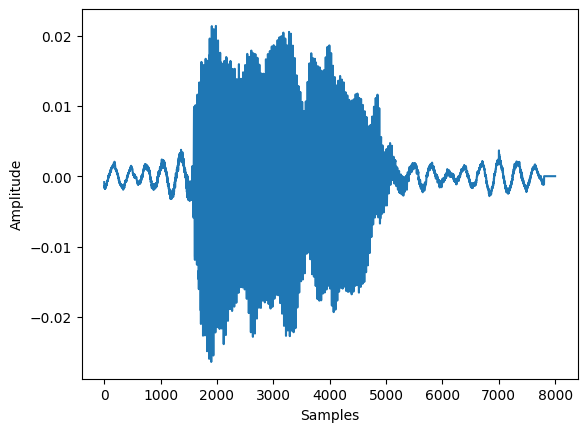

In [82]:
plt.plot(x[0])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

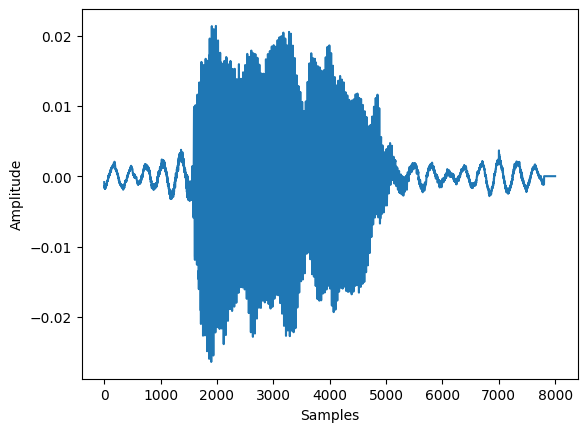

In [83]:
plt.plot(list(range(1, 8000 + 1, 1)), x[0])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

In [84]:
spectrogram_orig[7].shape

TensorShape([228, 131, 1])

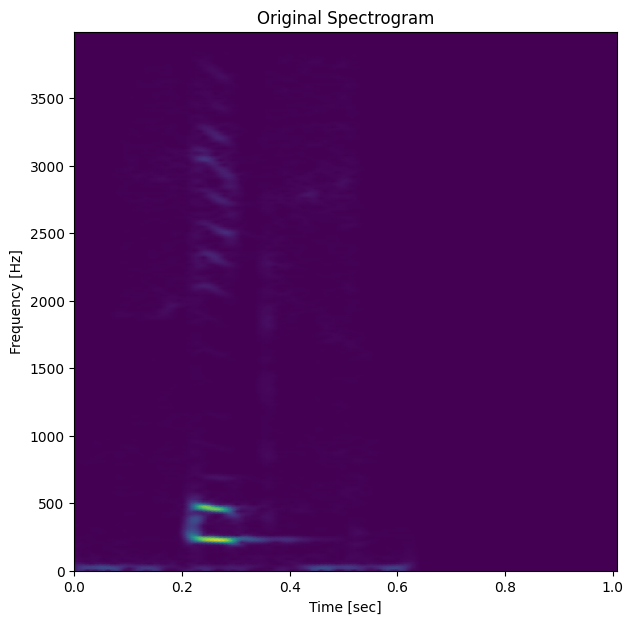

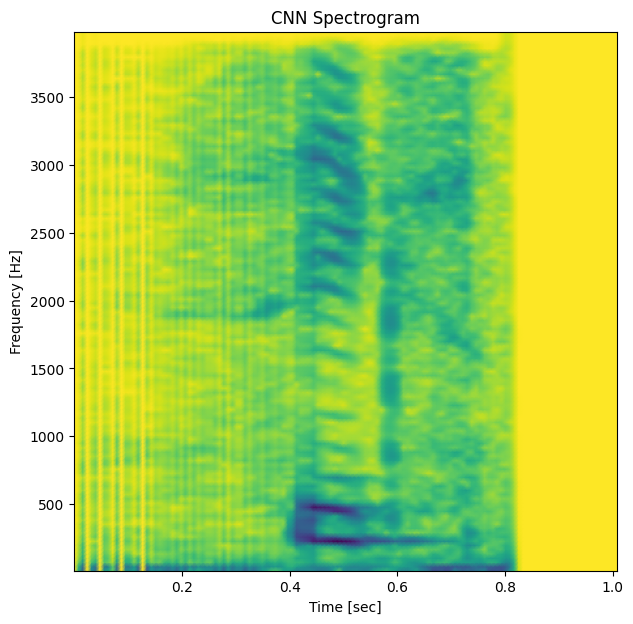

In [85]:
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pcolormesh(time_orig[7], frequency_orig[7], spectrogram_orig[7][:, :, 0], shading='gouraud')
ax1.set_title("Original Spectrogram")
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')

fig2, ax2 = plt.subplots(figsize=(7, 7))
ax2.pcolormesh(time_cnn[7], frequency_cnn[7], spectrogram_cnn[7][:, :, 0], shading='gouraud')
ax2.set_title("CNN Spectrogram")
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [sec]')

plt.show()

In [86]:
y_gender[29999], y_num[29999]

(<tf.Tensor: shape=(), dtype=int16, numpy=1>,
 <tf.Tensor: shape=(), dtype=int16, numpy=9>)

In [87]:
Audio(tf.squeeze(x[29999]), rate = 8000)

In [88]:
print(m18_1A_reconst.predict(tf.reshape(x[29999], (1, 8000, 1))))
print(m18_1B_reconst.predict(tf.reshape(x[29999], (1, 8000, 1))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
[[0.1405762 0.8594238]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
[[4.2176716e-02 8.2955137e-04 1.6692083e-04 1.1590381e-05 3.3029565e-01
  2.2243040e-04 7.2615156e-05 6.8327288e-05 9.0767135e-05 6.2606543e-01]]


In [89]:
# To have sanity check for the spectrogram actually being of that audio in reconstructed_wave 
#and thus, prove from the prediction made further on itself.

reconstructed_wave = librosa.griffinlim(spectrogram_orig[29999].numpy().squeeze(), n_iter = 32, hop_length = 62, win_length = 455, n_fft = 455)
Audio(reconstructed_wave, rate = 8000)

In [90]:
print(m_2A_reconst.predict(tf.reshape(spectrogram_cnn[29999], (1, 128, 128, 1))))
print(m_2B_reconst.predict(tf.reshape(spectrogram_cnn[29999], (1, 128, 128, 1))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
[[0.9983183  0.00168174]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[2.2850610e-07 4.7639499e-08 2.5212143e-10 3.9190002e-07 3.6852612e-06
  6.9763269e-07 1.4222315e-10 4.7156630e-07 7.5638418e-10 9.9999452e-01]]


In [91]:
del reconstructed_wave
gc.collect()

43690

In [92]:
# Spectrogram based Digit Predictions

y_spectrograms_num_preds = np.argmax(m_2B_reconst.predict(spectrogram_cnn), axis = 1)
print(f"{y_spectrograms_num_preds.shape, y_num.shape}")
y_spectrograms_num_preds, y_num

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
((30000,), TensorShape([30000]))


(array([0, 5, 8, ..., 6, 8, 9]),
 <tf.Variable 'Variable:0' shape=(30000,) dtype=int16, numpy=array([0, 5, 8, ..., 6, 8, 9], dtype=int16)>)

In [93]:
y_spectrograms_num_preds = tf.convert_to_tensor(y_spectrograms_num_preds, dtype = tf.int16)
y_num = tf.convert_to_tensor(y_num, dtype = tf.int16)

In [94]:
# Waveform based Digit Predictions

y_waveform_num_preds = np.argmax(m18_1B_reconst.predict(x), axis = 1)
print(f"{y_waveform_num_preds.shape, y_num.shape}")
y_waveform_num_preds, y_num

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
((30000,), TensorShape([30000]))


(array([0, 5, 8, ..., 6, 8, 9]),
 <tf.Tensor: shape=(30000,), dtype=int16, numpy=array([0, 5, 8, ..., 6, 8, 9], dtype=int16)>)

In [95]:
y_waveform_num_preds = tf.convert_to_tensor(y_waveform_num_preds, dtype = tf.int16)

In [96]:
#Spectrogram based Gender Predictions

y_spectrograms_gender_preds = np.argmax(m_2A_reconst.predict(spectrogram_cnn), axis = 1)
print(f"{y_spectrograms_gender_preds.shape, y_gender.shape}")
y_spectrograms_gender_preds, y_gender

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
((30000,), TensorShape([30000]))


(array([1, 1, 0, ..., 0, 0, 0]),
 <tf.Variable 'Variable:0' shape=(30000,) dtype=int16, numpy=array([1, 1, 0, ..., 0, 0, 1], dtype=int16)>)

In [97]:
y_spectrograms_gender_preds = tf.convert_to_tensor(y_spectrograms_gender_preds, dtype = tf.int16)
y_gender = tf.convert_to_tensor(y_gender, dtype = tf.int16)

In [98]:
# Waveform based Gender Predicitons

y_waveform_gender_preds = np.argmax(m18_1A_reconst.predict(x), axis = 1)
print(f"{y_waveform_gender_preds.shape, y_gender.shape}")
y_waveform_gender_preds, y_gender

938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
((30000,), TensorShape([30000]))


(array([1, 1, 0, ..., 0, 0, 1]),
 <tf.Tensor: shape=(30000,), dtype=int16, numpy=array([1, 1, 0, ..., 0, 0, 1], dtype=int16)>)

In [99]:
y_waveform_gender_preds = tf.convert_to_tensor(y_waveform_gender_preds, dtype = tf.int16)

Class 0: 24000 samples
Class 1: 6000 samples


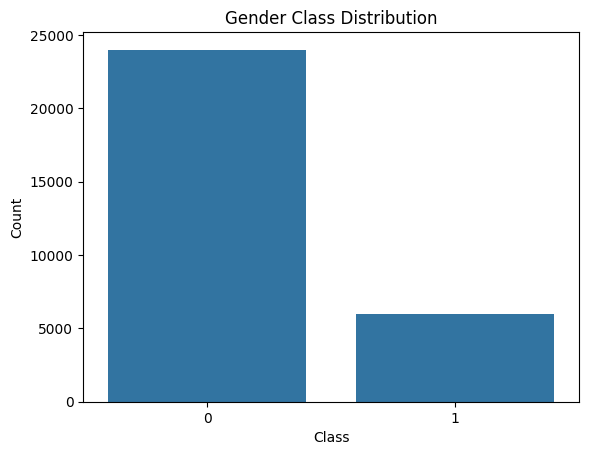

In [100]:
# Checked the data distributions of the benchmark for making good choice of metrics to evaluate performance of models.
classes, counts = np.unique(y_gender, return_counts = True)
for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt} samples")

sns.barplot(x=classes, y=counts)
plt.title("Gender Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Class 0: 3000 samples
Class 1: 3000 samples
Class 2: 3000 samples
Class 3: 3000 samples
Class 4: 3000 samples
Class 5: 3000 samples
Class 6: 3000 samples
Class 7: 3000 samples
Class 8: 3000 samples
Class 9: 3000 samples


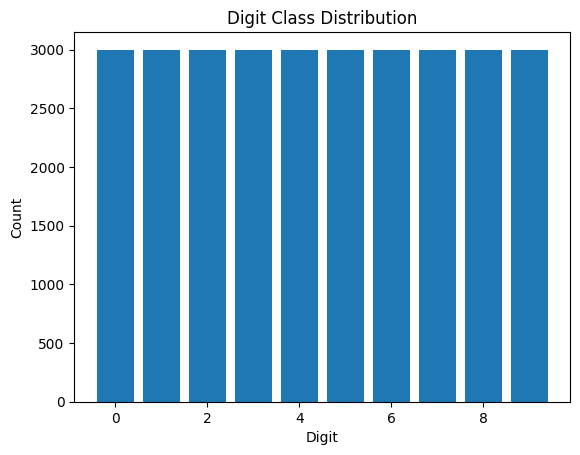

In [101]:
classes, counts = np.unique(y_num, return_counts=True)
for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt} samples")
    
plt.bar(classes, counts)
plt.title("Digit Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

In [102]:
del classes
del counts
gc.collect()

7897

In [103]:
# Imbalanced gender hence, chose precision, recall and all -- compiled within classification reports -- easier to generate and useful.
print("Waveform Gender Classification Report")
print(classification_report(y_gender, y_waveform_gender_preds, target_names = ["Male", "Female"]))
print("\n")
print("Spectrograms Gender Classification Report")
print(classification_report(y_gender, y_spectrograms_gender_preds, target_names = ["Male", "Female"]))

Waveform Gender Classification Report
              precision    recall  f1-score   support

        Male       0.90      1.00      0.95     24000
      Female       1.00      0.56      0.71      6000

    accuracy                           0.91     30000
   macro avg       0.95      0.78      0.83     30000
weighted avg       0.92      0.91      0.90     30000



Spectrograms Gender Classification Report
              precision    recall  f1-score   support

        Male       0.89      1.00      0.94     24000
      Female       1.00      0.52      0.68      6000

    accuracy                           0.90     30000
   macro avg       0.95      0.76      0.81     30000
weighted avg       0.91      0.90      0.89     30000



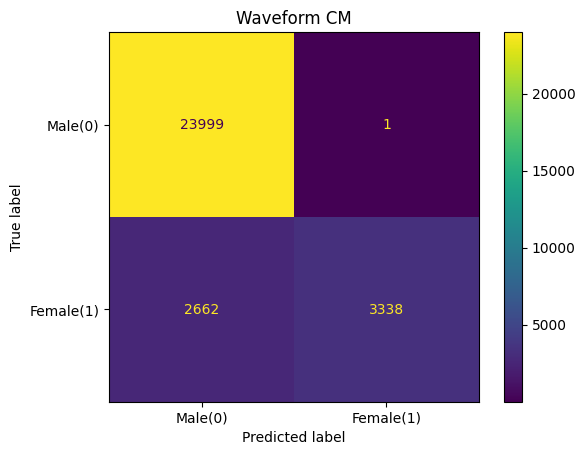

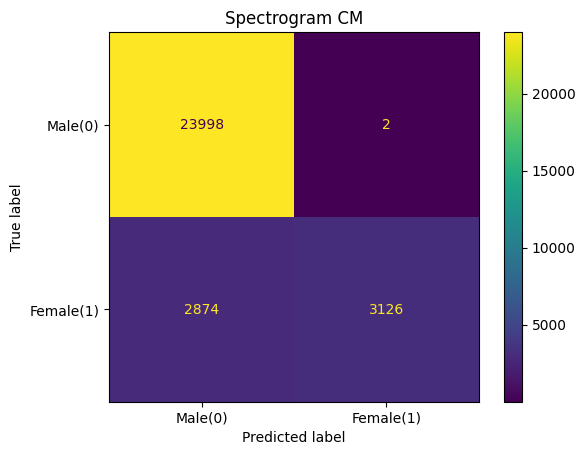

In [104]:
# Goes hand in hand with thee reports for better analytical understanding.

ConfusionMatrixDisplay(confusion_matrix(y_gender, y_waveform_gender_preds, labels = [0, 1]), display_labels = ["Male(0)", "Female(1)"]).plot()
plt.title("Waveform CM")
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_gender, y_spectrograms_gender_preds, labels = [0, 1]), display_labels = ["Male(0)", "Female(1)"]).plot()
plt.title("Spectrogram CM")
plt.show()

In [105]:
#balanced digit, hence accuracy doesn'r mislead.

print(f"Waveform Digit Classifier Performance: {accuracy_score(y_num, y_waveform_num_preds)}")
print(f"Spectrogram Digit Classifier Performance: {accuracy_score(y_num, y_spectrograms_num_preds)}")

Waveform Digit Classifier Performance: 0.9350666666666667
Spectrogram Digit Classifier Performance: 0.8910666666666667


In [106]:
!zip -r audio_data_test_benchmark_unzipped.zip /workspace/working/audio_data_test_benchmark_unzipped/*
!mv audio_data_test_benchmark_unzipped.zip /workspace/
!rm -rf /workspace/working/audio_data_test_benchmark_unzipped/

/bin/bash: line 1: /usr/bin/zip: Argument list too long
mv: cannot stat 'audio_data_test_benchmark_unzipped.zip': No such file or directory
